In [3]:
import pandas as pd
import os
import geopandas as gpd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr
import seaborn as sns
import scipy.stats as stats
from sklearn.inspection import permutation_importance

data_dir = os.path.join("../../data/embeddings/")
imd_file = os.path.join("../../", "data", "imd", "File_2_-_IoD2019_Domains_of_Deprivation.xlsx")

var_to_predict = 'imd_rank'

def evaluate_imd_model(y_true, y_pred, plot=True):
    """
    Evaluate regression predictions for IMD rank.
    
    Parameters:
    - y_true: array-like, true IMD ranks
    - y_pred: array-like, predicted IMD ranks
    - plot: bool, whether to show scatter plot of predicted vs actual
    
    Returns:
    - metrics: dictionary with RMSE, MAE, R2, Spearman correlation
    """
    # Metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    spearman_corr, _ = spearmanr(y_true, y_pred)

    metrics = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Spearman_rank_corr': spearman_corr}

    # Print metrics
    print("Model evaluation metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v:.3f}")

    # Scatter plot
    if plot:
        plt.figure(figsize=(6,6))
        plt.scatter(y_true, y_pred, alpha=0.7)
        plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', lw=2)
        plt.xlabel("True IMD Rank")
        plt.ylabel("Predicted IMD Rank")
        plt.title("Predicted vs Actual IMD Rank")
        plt.grid(True)
        plt.show()

    return metrics

### Get imd data

In [64]:
imd = pd.read_excel(imd_file, sheet_name="IoD2019 Domains", header=0)

# Rename columns to simpler versions
imd_col_map = {"LSOA code (2011)": "LSOA11CD",
    "Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)": "imd_rank",
    "Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)": "imd_decile"}
imd = imd.rename(columns=imd_col_map)

# 2. Using mean embedding per LSOA, based on mean each location

### Get data

In [5]:
avg_embeddings = pd.read_pickle(data_dir +"mean_embeddings_per_lsoa_from_mean.pkl")
avg_embeddings_with_imd = pd.merge(left=avg_embeddings, right=imd, on="LSOA11CD")

### Build model

Model evaluation metrics:
RMSE: 5830.461
MAE: 4684.772
R2: 0.631
Spearman_rank_corr: 0.764


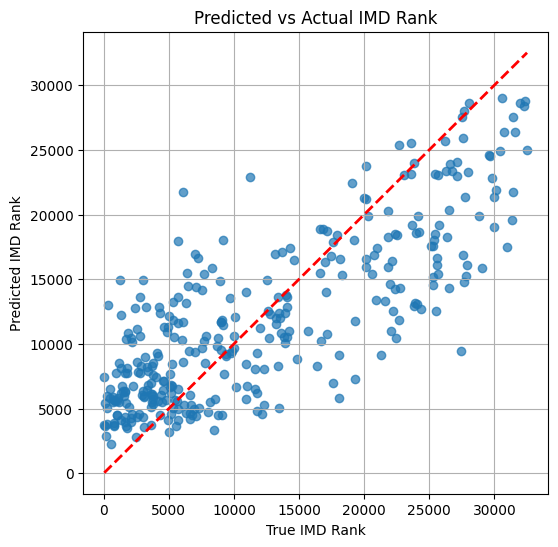

In [58]:
X = np.stack(avg_embeddings_with_imd["mean_embedding"].values)     # shape (n_points, embed_dim)
y = avg_embeddings_with_imd['imd_rank'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a model (Random Forest Regressor example)
rf = RandomForestRegressor(n_estimators=200, random_state=2)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)

# Usage example:
metrics = evaluate_imd_model(y_test, y_pred)

## Feature importance
0.633
31, 357, 545, 677, 284

In [ ]:
# Permutation
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

In [69]:
# Feature importance
importances = rf.feature_importances_  # shape: (embed_dim,)
indices = np.argsort(importances)[::-1]  # descending order

In [70]:
top_n =20
# Compute top 3 features by mean importance
sorted_idx = perm_importance.importances_mean.argsort()[-top_n:]  # top 3
# Top FI
top_indices = indices[:top_n]
top_importances = importances[top_indices]

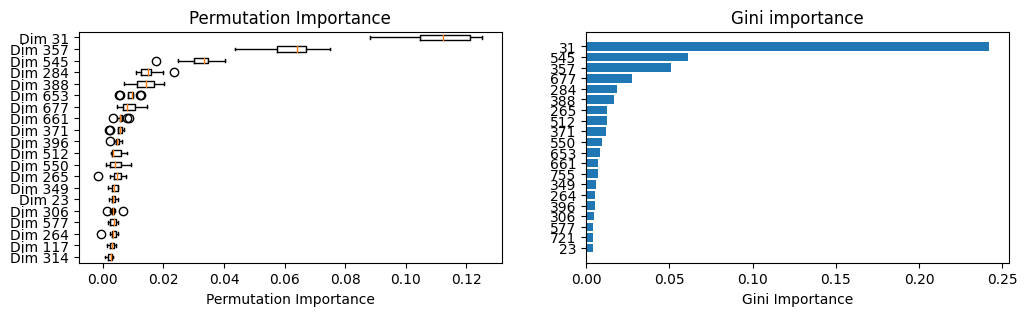

In [86]:
# Create boxplot
fig, axs = plt.subplots(ncols=2, figsize=(12, 3))

# Use transpose: (n_repeats x n_features)
axs[0].boxplot(perm_importance.importances[sorted_idx].T,
           vert=False, 
           labels=[f"Dim {i}" for i in sorted_idx])  # labels = column indices
axs[0].set_xlabel("Permutation Importance")
axs[0].set_title(f"Permutation Importance");


# Create positions for bars
x_pos = np.arange(len(top_indices))
axs[1].barh(range(top_n), importances[indices][:top_n][::-1])
axs[1].set_yticks(range(top_n), indices[:top_n][::-1])
axs[1].set_xlabel("Gini Importance")
# axs[1].set_ylabel("Embedding Dimension")
axs[1].set_title(f"Gini importance");